#### Import Package

In [1]:
import os
import numpy as np
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt

from core.system import *
from core.operation import *

import warnings

warnings.filterwarnings('ignore')

#### Load Data

In [12]:
# Params
start = '2005-01-01'
current_date = (date.today()).strftime('%Y-%m-%d')
etf_list = ['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU']

In [13]:
# Read in ETF data from FMP
T = [1]
sector_ret = get_data_fmp(ticker_list=etf_list, start=start, current_date=current_date)
sector_ret = sector_ret[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
sector_ret = sector_ret.rename(columns={'Adj Close': 'Close'})
sector_ret = sector_ret.loc[~sector_ret.index.duplicated(keep='first')]

Fetching data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.65s/ticker]


In [14]:
# # Read in ETF data from FMP
# sector_fund = get_fund_fmp(ticker_list=etf_list, start=start, current_date=current_date)

In [ ]:
# Create returns
sector_ret = create_return(sector_ret, T)
sector_ret = sector_ret.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
sector_ret = sector_ret.dropna()

#### Correlation

In [20]:
def corr_table(df):
    df = df.unstack('ticker').swaplevel(axis=1)
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df = df.fillna(0)
    correlation_matrix = df.corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    correlation_matrix_masked = correlation_matrix.mask(mask)
    formatted_corr_matrix = correlation_matrix_masked.applymap(lambda x: f"{x:.4f}" if np.isfinite(x) else "")
    return formatted_corr_matrix

In [21]:
corr_table(sector_ret)

,XLB_RET_01,XLE_RET_01,XLF_RET_01,XLI_RET_01,XLK_RET_01,XLP_RET_01,XLU_RET_01,XLV_RET_01,XLY_RET_01
XLB_RET_01,,,,,,,,,
XLE_RET_01,0.7557,,,,,,,,
XLF_RET_01,0.7364,0.6296,,,,,,,
XLI_RET_01,0.8664,0.7165,0.8059,,,,,,
XLK_RET_01,0.7471,0.5859,0.7014,0.7942,,,,,
XLP_RET_01,0.6505,0.5089,0.6278,0.7160,0.6787,,,,
XLU_RET_01,0.5795,0.5180,0.5148,0.6022,0.5496,0.7052,,,
XLV_RET_01,0.6882,0.5475,0.6418,0.7407,0.7212,0.7348,0.6104,,
XLY_RET_01,0.7611,0.5865,0.7668,0.8325,0.8444,0.6872,0.5371,0.7022,


#### Statistics

In [123]:
# Unstack 
stat = sector_ret.unstack('ticker')['RET_01']

In [139]:
# Get positive/negative return count
pos = []
neg = []
tickers = []
for ticker in stat.columns:
    pos.append(len(stat.loc[stat[ticker] > 0]))
    neg.append(len(stat.loc[stat[ticker] < 0]))
    tickers.append(ticker)
pos_neg_ret = pd.DataFrame(data={'pos':pos, 'neg':neg}, index=tickers)
pos_neg_ret

,pos,neg
XLB,2559,2202
XLE,2507,2279
XLF,2460,2247
XLI,2591,2163
XLK,2618,2124
XLP,2548,2154
XLU,2565,2170
XLV,2557,2183
XLY,2588,2180


#### Beta Premia

In [88]:
# Read in SPY data from FMP
T = [1]
spy = get_data_fmp(ticker_list=['SPY'], start=start, current_date=current_date)
spy = spy[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
spy = spy.rename(columns={'Adj Close': 'Close'})

Fetching data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/ticker]


In [89]:
# Create returns and unstack dataframe to only have 'date' index
spy = create_return(spy, T)
spy = spy.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
spy = spy.unstack('ticker').swaplevel(axis=1)
spy.columns = ['_'.join(col).strip() for col in spy.columns.values]
spy = spy.fillna(0)

In [90]:
# Execute Rolling OLS
T = [1]
window = 21
ret = f'RET_01'
factor_col_spy = spy.columns
beta_spy = rolling_ols_parallel(data=sector_ret, ret=ret, factor_data=spy, factor_cols=factor_col_spy.tolist(), window=window, name=f'spy_01')
defense = beta_spy[[f'SPY_RET_01_spy_01_{window}']]
defense.columns = ['beta']
defense = defense.dropna()

#### EWP Long-Only Portfolio

In [91]:
# EWP
ewp_weight = 1 / len(sector_ret.index.get_level_values('ticker').unique())
ewp_ret = sector_ret.groupby('date').apply(lambda x: (ewp_weight * x['RET_01']).sum())

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-01-05   2005-01-05
End Period                 2024-03-01   2024-03-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          331.58%      534.48%
CAGR﹪                     5.41%        6.88%

Sharpe                     0.49         0.61
Prob. Sharpe Ratio         98.42%       99.59%
Smart Sharpe               0.45         0.55
Sortino                    0.69         0.85
Smart Sortino              0.63         0.77
Sortino/√2                 0.49         0.6
Smart Sortino/√2           0.44         0.55
Omega                      1.13         1.13

Max Drawdown               -56.47%      -52.53%
Longest DD Days            1982         1220
Volatility (ann.)          19.31%       18.77%
R^2                        0.96         0.96
Information Ratio          0.03         0.03
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-10-15,2009-03-09,2011-02-15,1220,-52.530458,-47.929190
2,2020-02-20,2020-03-23,2020-11-06,261,-36.904274,-31.774678
3,2011-07-08,2011-10-03,2012-02-02,210,-18.614514,-16.957158
4,2018-09-24,2018-12-24,2019-04-11,200,-18.470306,-15.143610
5,2022-03-30,2022-09-30,2023-07-11,469,-16.943431,-16.049988


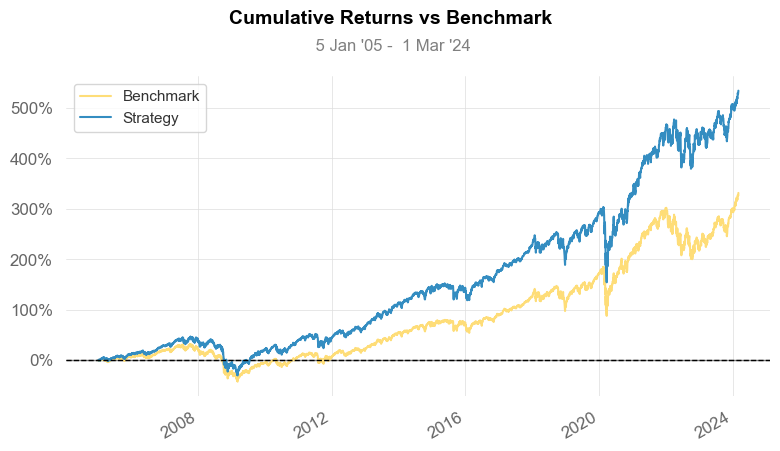

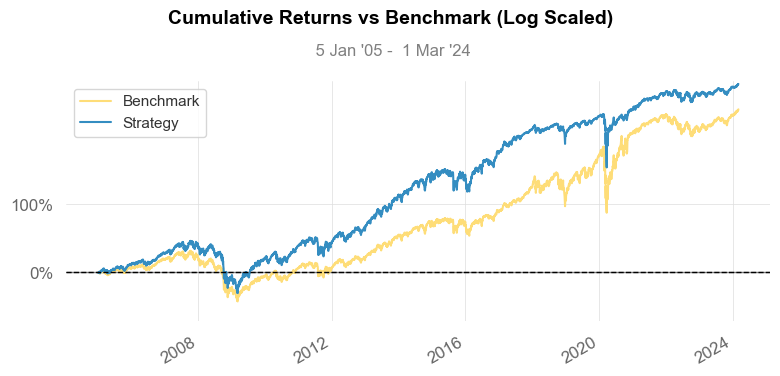

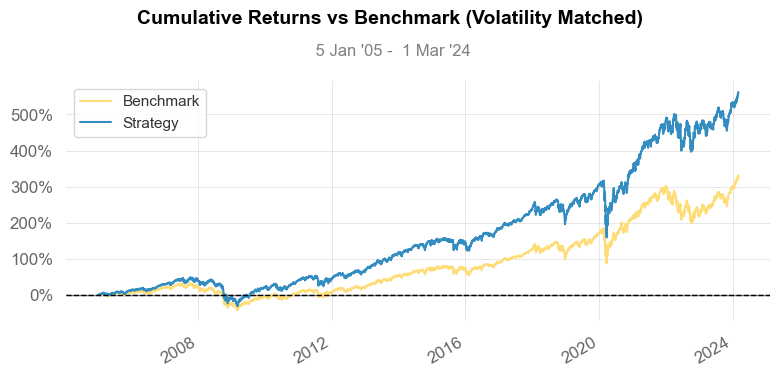

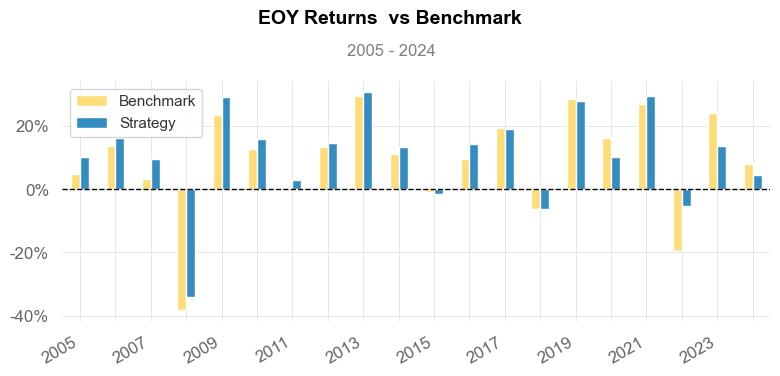

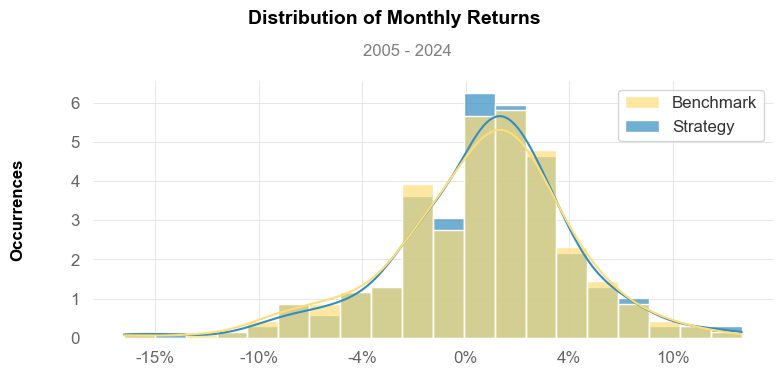

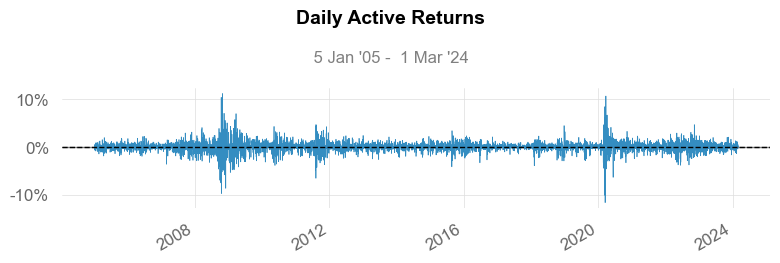

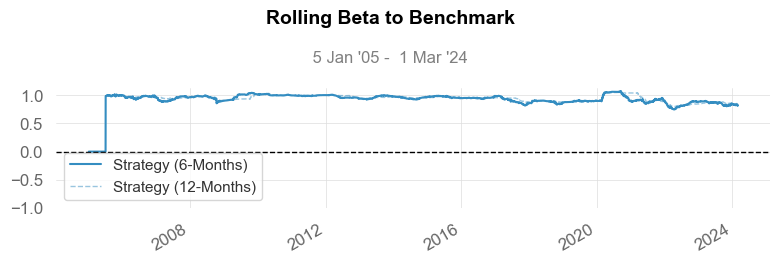

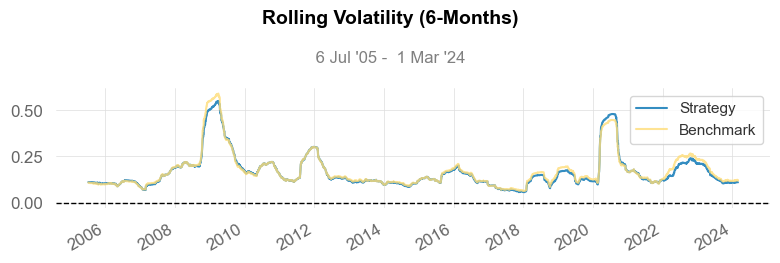

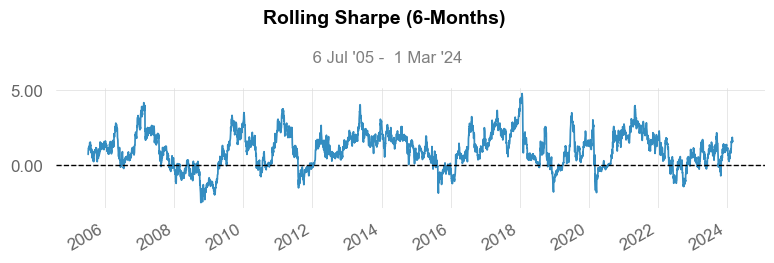

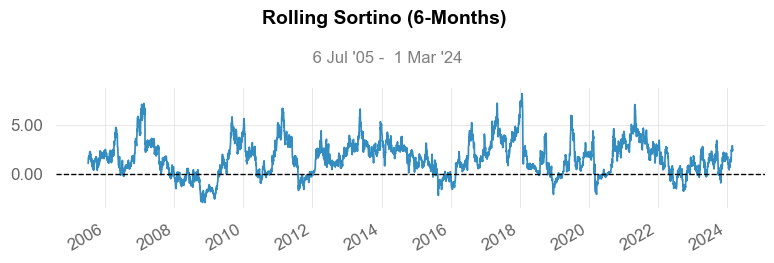

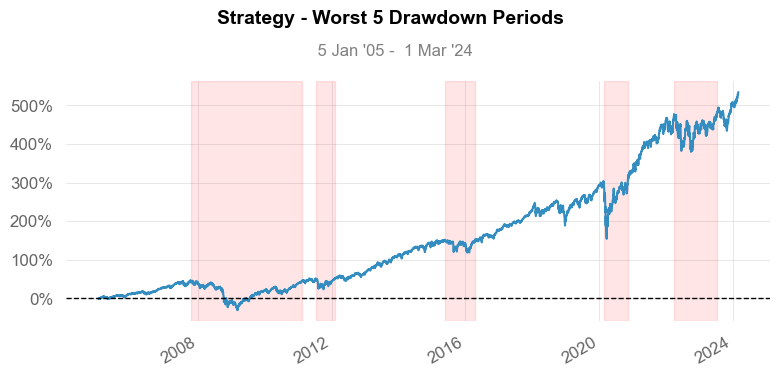

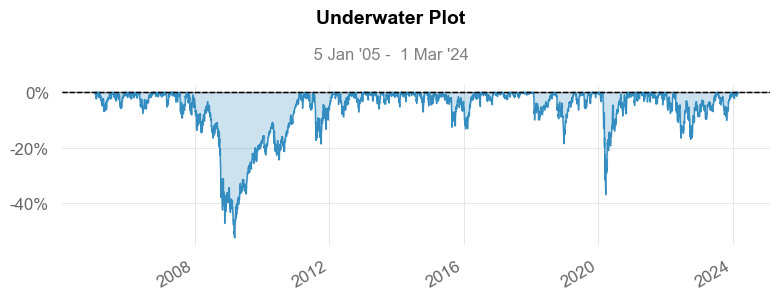

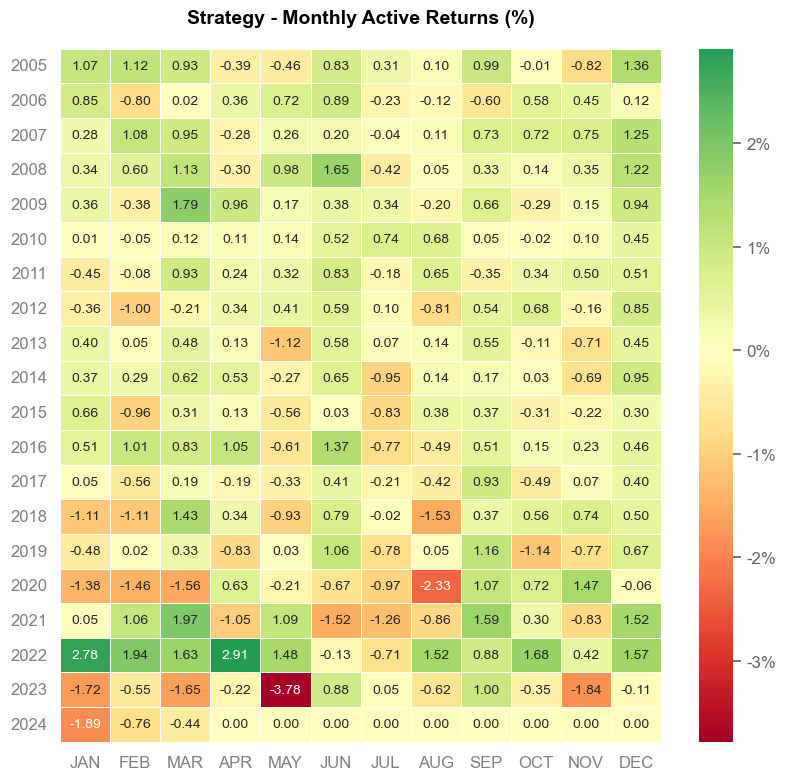

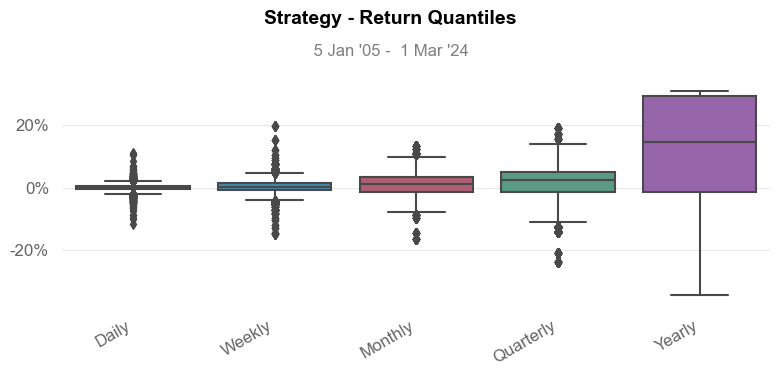

In [92]:
# Report
qs.reports.full(ewp_ret, 'SPY')

#### Risk Premia Portfolio

In [93]:
# Join
risk_premia = defense.join(sector_ret)

<AxesSubplot:xlabel='date'>

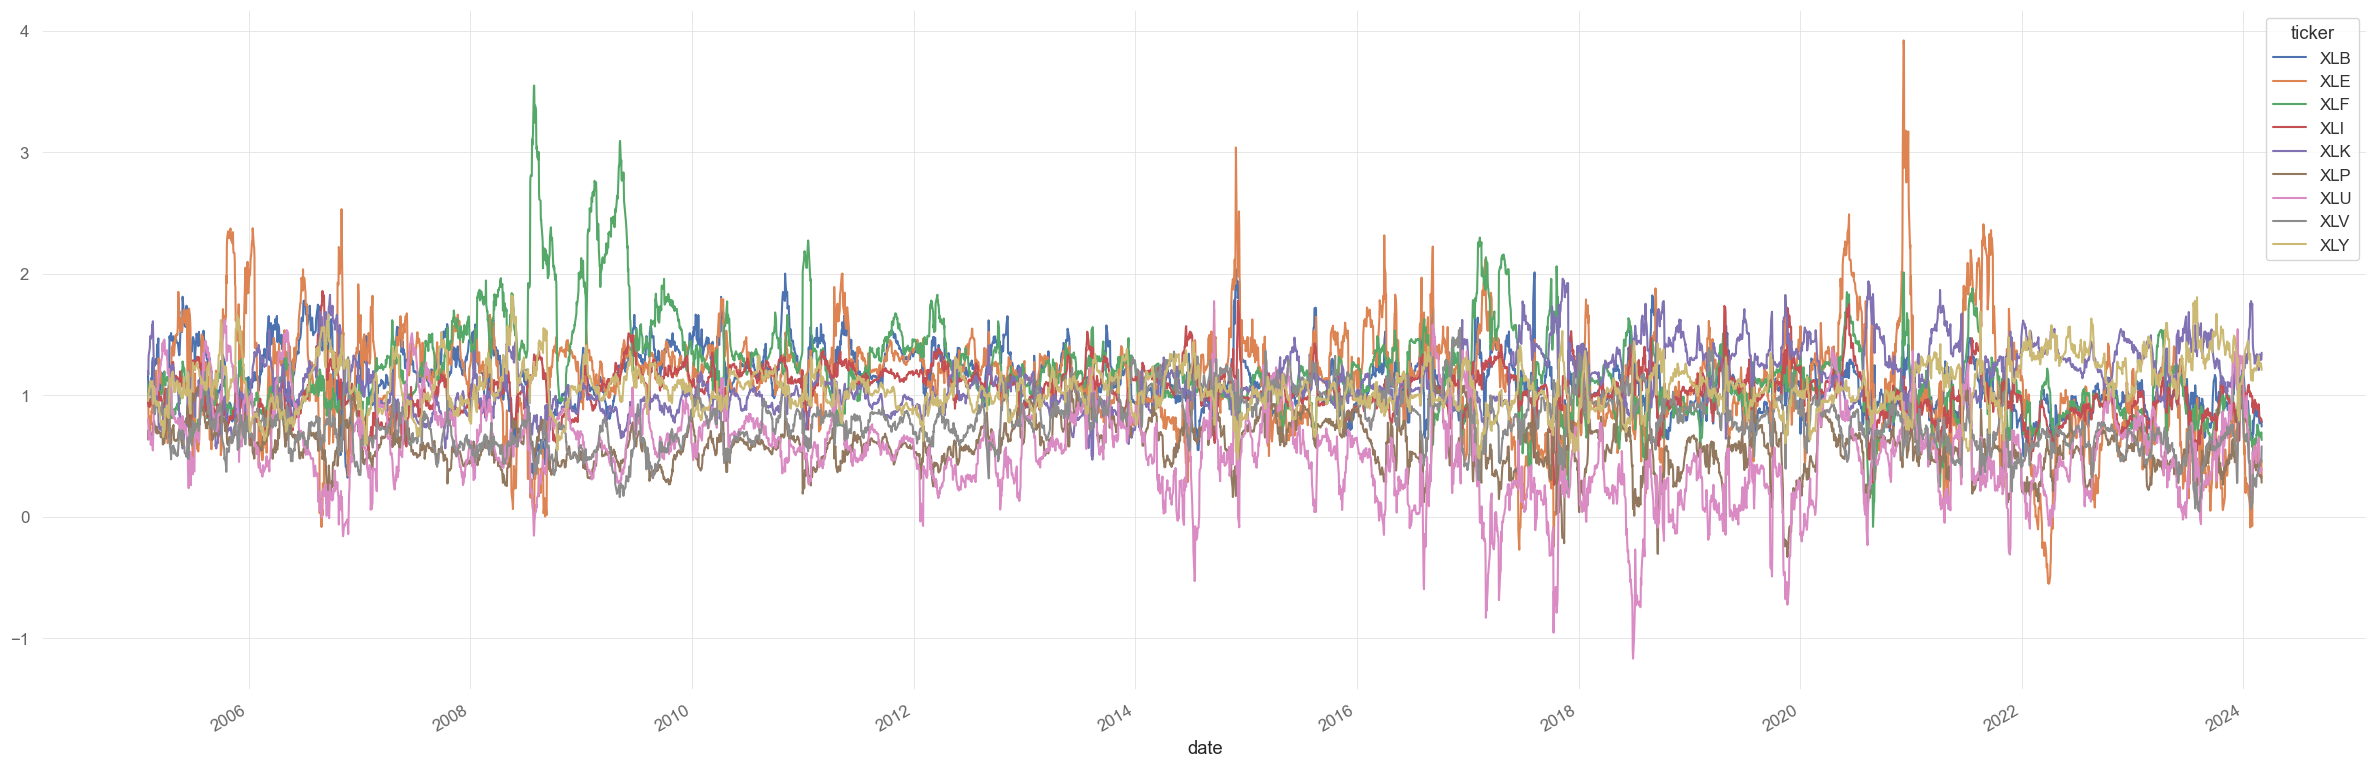

In [94]:
# Plot Beta
risk_premia.unstack('ticker')['beta'].plot(figsize=(30,10))

In [106]:
# Long if beta > 1 and Short if beta < 1
risk_premia['signal'] = np.where(risk_premia['beta'] > 1, 1, -1)

In [114]:
# Initialize all signals to 0
risk_premia['signal'] = 0

# Find the index of the max and min beta for each date
idx_max_beta = risk_premia.groupby('date')['beta'].idxmax()
idx_min_beta = risk_premia.groupby('date')['beta'].idxmin()

# Set the signal for the highest beta stock to 1 and for the lowest beta stock to -1
risk_premia.loc[idx_max_beta, 'signal'] = 1
risk_premia.loc[idx_min_beta, 'signal'] = -1

In [115]:
# Shift return
risk_premia['shift_ret'] = risk_premia.groupby('ticker')['RET_01'].shift(-1)

In [116]:
# Calculate weighted return
signal_abs_sum = risk_premia.groupby('date')['signal'].transform(lambda x: x.abs().sum())
risk_premia['norm_weight'] = risk_premia['signal'] / signal_abs_sum
risk_premia['weight_ret'] = risk_premia['norm_weight'] * risk_premia['shift_ret']

In [117]:
# Calculate portfolio return index
port_ret = risk_premia.groupby('date')['weight_ret'].sum()

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-02-03   2005-02-03
End Period                 2024-03-01   2024-03-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          329.99%      31.5%
CAGR﹪                     5.42%        1.0%

Sharpe                     0.49         0.17
Prob. Sharpe Ratio         98.4%        77.45%
Smart Sharpe               0.46         0.16
Sortino                    0.69         0.26
Smart Sortino              0.64         0.24
Sortino/√2                 0.49         0.18
Smart Sortino/√2           0.45         0.17
Omega                      1.03         1.03

Max Drawdown               -56.47%      -31.1%
Longest DD Days            1982         2129
Volatility (ann.)          19.34%       14.17%
R^2                        0.01         0.01
Information Ratio          -0.02        -0.02
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2006-11-16,2008-07-11,2009-04-30,897,-31.102101,-26.482593
2,2014-08-06,2016-06-24,2020-06-03,2129,-27.403731,-25.844988
3,2021-11-24,2022-05-23,2024-03-01,829,-26.889420,-24.118969
4,2009-05-08,2011-11-28,2014-01-06,1705,-19.737826,-18.875027
5,2020-06-08,2020-11-02,2021-02-17,255,-18.043741,-16.456646


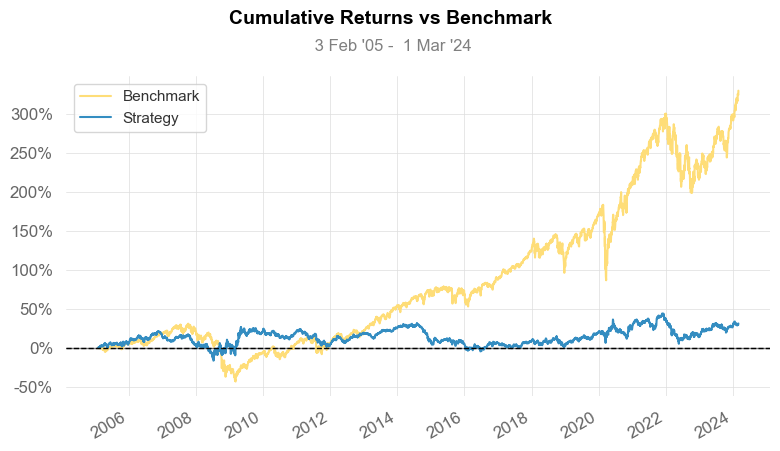

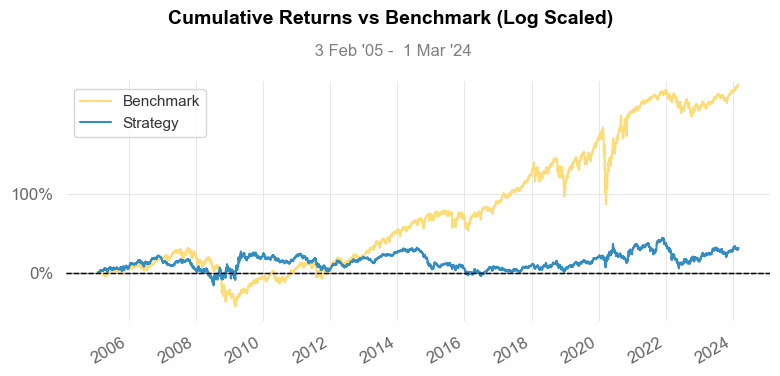

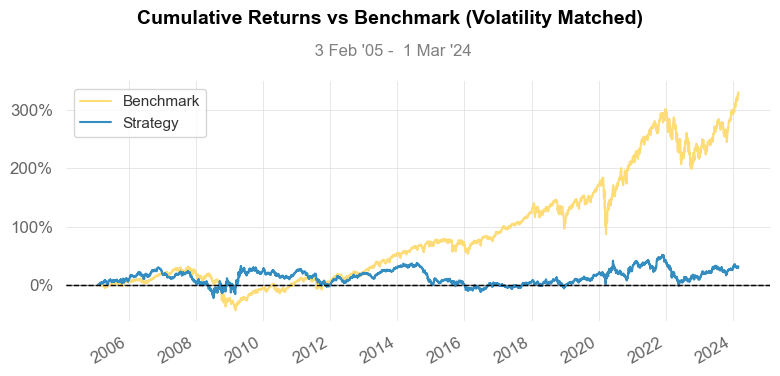

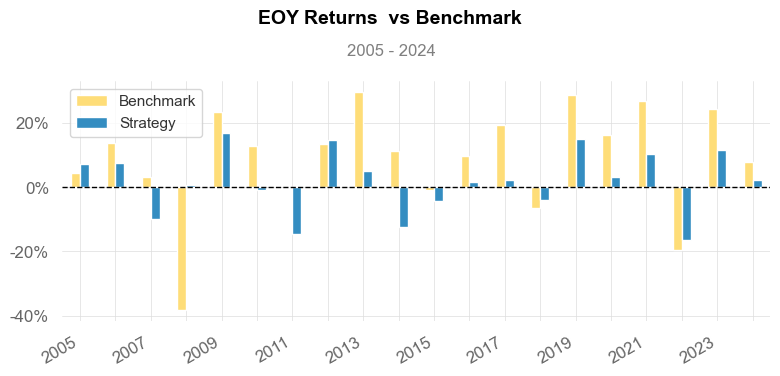

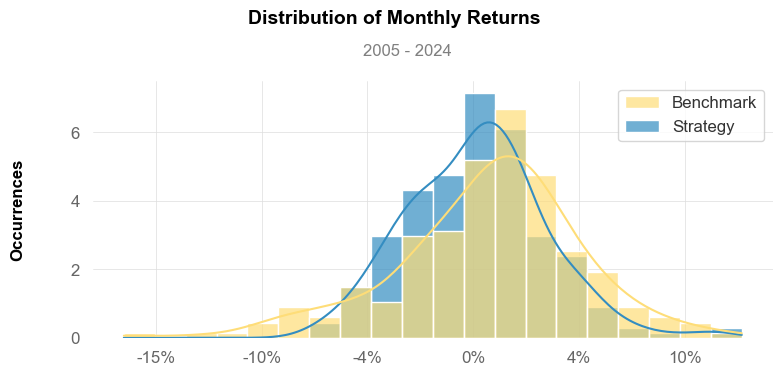

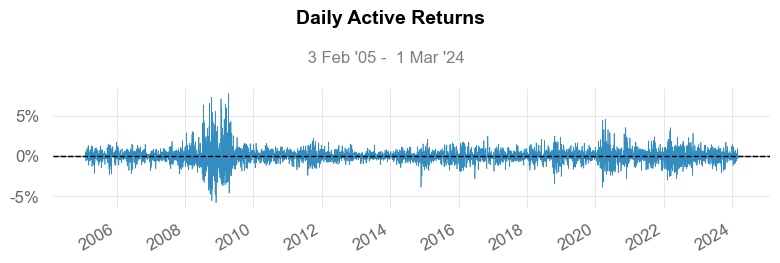

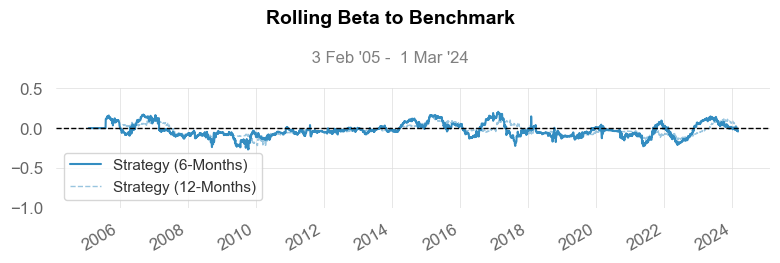

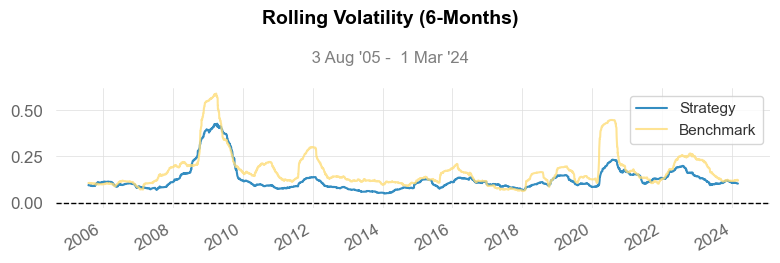

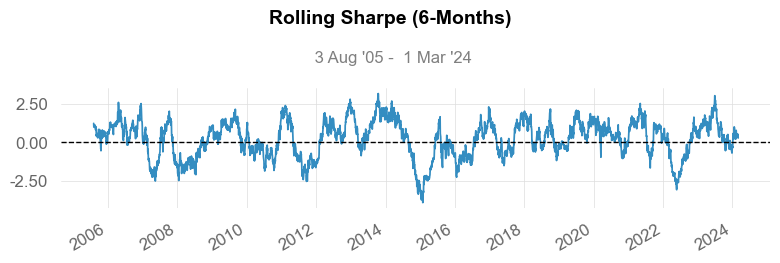

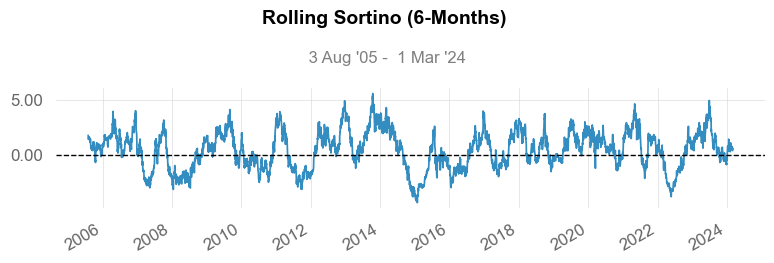

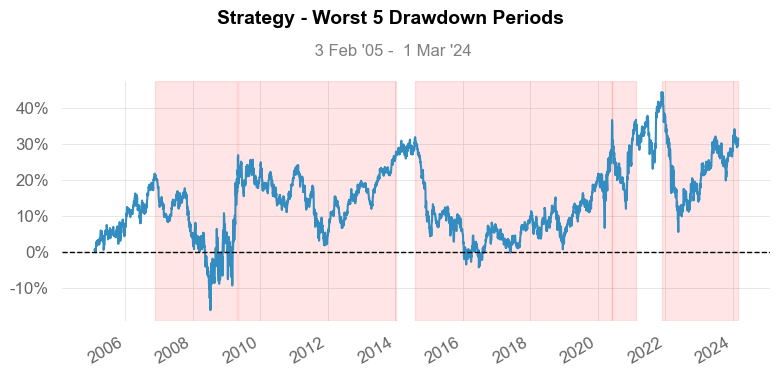

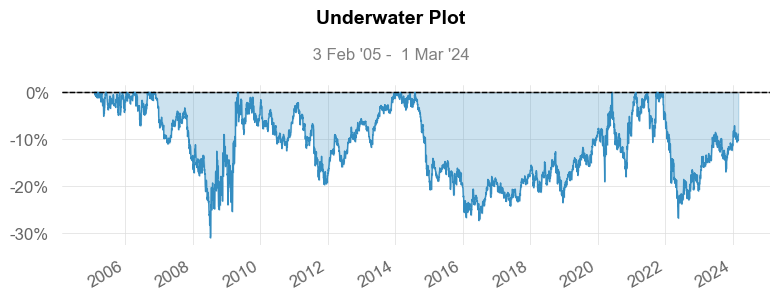

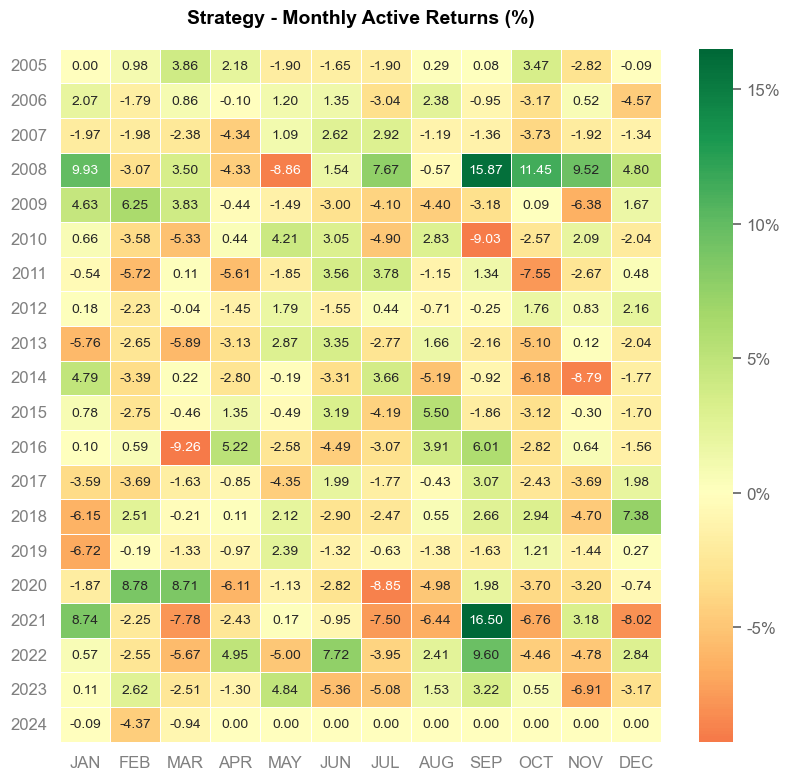

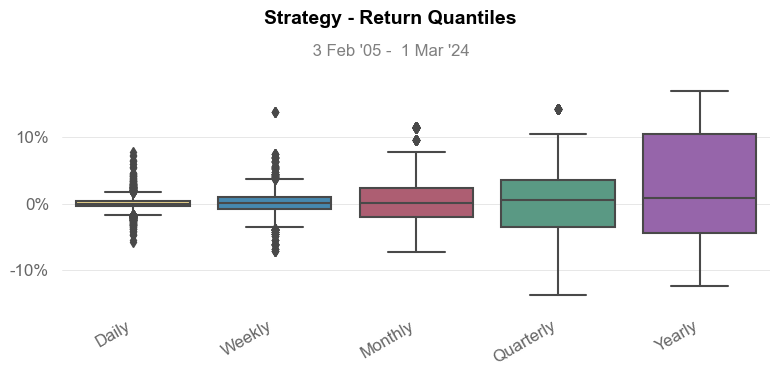

In [118]:
# Report
qs.reports.full(port_ret, 'SPY')